In [22]:
import os
import os.path as osp
import configparser
import pylab as py
import pandas as pd
import math
import scipy
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import seaborn as sns
from typing import List

In [23]:
config_file_path = osp.join(os.getcwd(), 'config.ini')
parser = configparser.ConfigParser()
parser.read(config_file_path)
result_folder_path = parser['DATA_PATH']['somet_result_path'] # Initialize result path

In [24]:
def load_results(dataset_result_path: str) -> np.array(float):
    result_file_paths = [osp.join(dataset_result_path, result_file_path) for result_file_path in os.listdir(dataset_result_path)]
    results = []
    for result_file_path in result_file_paths:
        result = pd.read_csv(result_file_path)
        results += result['balanced_accurary_score'].values.tolist()
    results = np.array(results)
    return results

In [25]:
def load_results_from_datasets(dataset_result_paths: List[str]) -> np.array(float):
    results = []
    for dataset_result_path in dataset_result_paths:
        results += load_results(dataset_result_path).tolist()
    results = np.array(results)
    return results

In [26]:
def visualize_data_distribution(data):
    plt.figure(figsize=(15, 6))
    
    # Plot histogram data distribution
    plt.subplot(121)
    plt.xlabel('Non-absolute difference of balanced accuracy score')
    plt.ylabel('Frequency of occurences')
    plt.hist(data, bins=30)

    # Plot QQ-plot
    plt.subplot(122)
    stats.probplot(data, dist='norm', plot=py)
    plt.show()

# Prepare results for RQ1.1 Analysis

In [27]:
USE_SINGLE_DATASET = False

In [28]:
if USE_SINGLE_DATASET:
    # -- Uncomment the dataset that you wanna load -- #
    ### Only low-sampling-rate dataset is loaded
    dataset_name = 'AffectiveROAD'
    # dataset_name = 'DCU_NVT_EXP1'
    # dataset_name = 'WESAD_WRIST'

    # Load results of General 
    detector_type = 'General'
    general_result_path = osp.join(result_folder_path, dataset_name, detector_type)
    general_detector_results = load_results(general_result_path)

    # Load results of Personal
    detector_type = 'Personal'
    personal_result_path = osp.join(result_folder_path, dataset_name, detector_type)
    personal_detector_results = load_results(personal_result_path)
else:
    dataset_list = ["OLD_AffectiveROAD", 'OLD_DCU_NVT_EXP1', 'OLD_WESAD_WRIST']
    # Load results of General 
    detector_type = 'General'
    general_result_paths = [osp.join(result_folder_path, dataset_name, detector_type) for dataset_name in dataset_list]
    general_detector_results = load_results_from_datasets(general_result_paths)

    # Load results of Personal
    detector_type = 'Personal'
    personal_result_paths = [osp.join(result_folder_path, dataset_name, detector_type) for dataset_name in dataset_list]
    personal_detector_results = load_results_from_datasets(personal_result_paths)
    print(len(personal_detector_results))

FileNotFoundError: [Errno 2] No such file or directory: '/home/nvtu/PhD_Work/StressDetection/DATA/OLD_RESULTS/DCU_NVT_EXP1/General'

In [ ]:
# Compute non-absolute difference of balanced accuracy
# We assume that personal-specific model is statistically better than general cross-population model
non_absolute_diff = personal_detector_results - general_detector_results

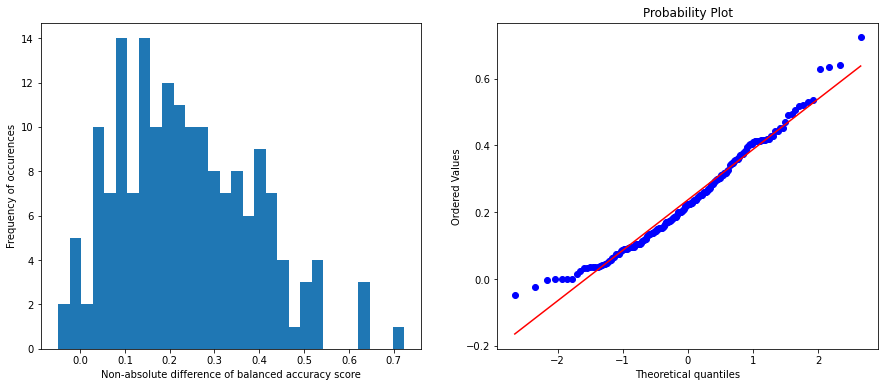

In [ ]:
# Plot data distribution
visualize_data_distribution(non_absolute_diff)

In [ ]:
preprocessed_result_folder = osp.join(os.getcwd(), 'AnalyseExperimentResult')
if not osp.exists(preprocessed_result_folder):
    os.makedirs(preprocessed_result_folder)

In [ ]:
# Save general detector results and personal detector results separately for analysis
detector_result_fp = osp.join(preprocessed_result_folder, 'RQ1-1Results.csv')
results = { 'general_score': general_detector_results.tolist(), 'personal_score': personal_detector_results.tolist() }
df = pd.DataFrame(results)
df.to_csv(detector_result_fp, index = False)

# Prepare results for RQ1.2 Analysis

In [ ]:
detector_type = 'Personal' # As we prove that using personal-specific stress detector is better

In [ ]:
# Initialize WESAD_CHEST and WESAD_WRIST results
wesad_chest_path = osp.join(result_folder_path, 'WESAD_CHEST', detector_type)
wesad_wrist_path = osp.join(result_folder_path, 'WESAD_WRIST', detector_type)

# Combine results from different detectors and load them all
wesad_chest_results = load_results(wesad_chest_path)
wesad_wrist_results = load_results(wesad_wrist_path)

In [ ]:
# Save general detector results and personal detector results separately for analysis
detector_result_fp = osp.join(preprocessed_result_folder, 'RQ1-2Results.csv')
results = { 'wrist_score': wesad_wrist_results.tolist(), 'chest_score': wesad_chest_results.tolist() }
df = pd.DataFrame(results)
df.to_csv(detector_result_fp, index = False)